# Lecture 2 - Task 2: Hamiltonian Classification

__This Code was written and kindly lent by Keith Butler (SciML, STFC) and adapted for this course. All typos are mine :)__

The aim of the tutorial is to create a classifier for two different Hamiltonians, based on inelastic neutron scattering data (INS). Don't worry too much if you have no idea what a Hamiltonian is (https://en.wikipedia.org/wiki/Hamiltonian_mechanics#Mathematical_formalism), or how inelastic neutron scattering works (https://en.wikipedia.org/wiki/Inelastic_neutron_scattering), we simply need to know that by using INS, we can indeed determine the Hamiltonian of the system we are measuring. This sort of problem is a nice example for ML, and the methodology can be applied for a lot of other problems. 

Jos Cooper

***
## Imports

First we must import the necessary libraries for the tutorial.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Import TensorFlow and Keras.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Check we are running a TensorFlow version > 2.0
print(tf.__version__)
plt.style.use('ggplot')

2.4.1


***
## Data Retrieval and Processing

In our previous network, we downloaded a dataset that had been rather nicely curated for us and came with its own loader. Since this is generally not the case, we need to write a data generator. The data is in an HDF5 file (these are super useful and you will see a lot of them in ML), and probably can't all be loaded into memory at once, so we write something to load data in "chunks".

In [2]:
!gdown --id 11N87FJkVhjjhhzv8cc-vwUvtZKWtHg5_
!gdown --id 1dV1ATYMwH8q93_kXR-w8JpiXEdLNclPy
data_path = '/content'

Downloading...
From: https://drive.google.com/uc?id=11N87FJkVhjjhhzv8cc-vwUvtZKWtHg5_
To: /content/test.h5
214MB [00:02, 95.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dV1ATYMwH8q93_kXR-w8JpiXEdLNclPy
To: /content/train.h5
640MB [00:05, 113MB/s] 


In [3]:
# Define the image size.
IMG_HEIGHT = 20
IMG_WIDTH = 200
N_CHANNELS = 1
N_CLASSES = 2

# Define our generator that loads "chunks" of data at a time.
def hdf5_generator(path, buffer_size=32):
    """Load INS data from the given directory.

    Args:
        path (string): path to the directory containing the HDF5 file.
        buffer_size (int): number of images to read at one time.
    """
    # Load the given file.
    with h5py.File(path, 'r') as handle:
        n_samples, h, w, c = handle['images'].shape
        for i in range(0, n_samples, buffer_size):
            images = handle['images'][i:i+buffer_size, ..., :1]
            labels = handle['labels'][i:i+buffer_size]
            yield images, labels

# Create the training dataset.
train_dataset = tf.data.Dataset.from_generator(lambda: hdf5_generator(path=data_path + '/train.h5'), 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), 
                                                              (None, N_CLASSES,)))

# Create the test dataset.
test_dataset = tf.data.Dataset.from_generator(lambda: hdf5_generator(path=data_path + '/test.h5'), 
                                              output_types=(tf.float32, tf.float32),
                                              output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), 
                                                             (None, N_CLASSES,)))
print(train_dataset)
print(test_dataset)

<FlatMapDataset shapes: ((None, 20, 200, 1), (None, 2)), types: (tf.float32, tf.float32)>
<FlatMapDataset shapes: ((None, 20, 200, 1), (None, 2)), types: (tf.float32, tf.float32)>


Let's display some examples of our data.

1.0


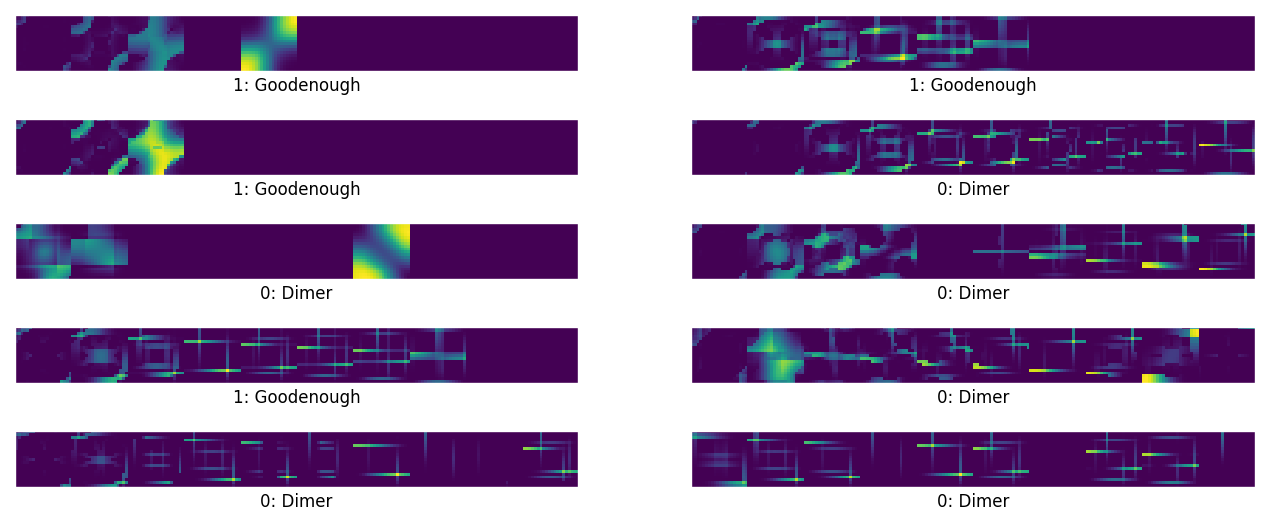

In [4]:
# Load the first buffer (with 32 elements by default).
images, labels = list(test_dataset.take(1))[0]
print(np.max(images[0]))

# Plot some images and labels from the sample.
nplot = 10
fig, axes = plt.subplots(nplot // 2, 2, figsize=(16, nplot / 1.5), dpi=100)
for ax, image, label in zip(axes.flatten(), images, labels):
    ax.matshow(image[:,:,0])
    ax.set_xlabel('0: Dimer' if label[0] < .5 else '1: Goodenough', c='k')
    ax.set_xticks([])
    ax.set_yticks([])


***
# Tasks
1. Create a network that takes the images as input, flattens them, and then has two dense layers of 16 then 8 nodes. The final layer should use a sigmoid activation function to classify the output into one of the two classes.
2. Compile the model using the ADAM optimiser and a binary cross entropy loss function. Use accuracy as the model's metric. Some additional metrics to measure are:
 1. keras.metrics.TruePositives(name='true_positives') <br>
 2. keras.metrics.FalsePositives(name='false_positives') <br>
 3. keras.metrics.TrueNegatives(name='true_negatives') <br>
 4. keras.metrics.FalseNegatives(name='false_negatives')
3. Train the model for 10 epochs and examine the accuracy and loss of both the training and the validation datasets.
4. Improve on this model.

***
## Answers

1. The following defines the network architecture:

In [5]:
model = Sequential()
model.add(Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS)))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(N_CLASSES, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 4000)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                64016     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 18        
Total params: 64,170
Trainable params: 64,170
Non-trainable params: 0
_________________________________________________________________


2. Next comes model compilation:

In [6]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy',
                        keras.metrics.TruePositives(name='true_positives'),
                        keras.metrics.FalsePositives(name='false_positives'),
                        keras.metrics.TrueNegatives(name='true_negatives'),
                        keras.metrics.FalseNegatives(name='false_negatives')])

3. Now we train the compiled model:

In [7]:
history = model.fit(train_dataset, validation_data=test_dataset, epochs=10)

# Print the final values of each metric after training for validation data.
print('Right for Dimer: %d' % history.history['val_true_positives'][-1])
print('Wrong for Dimer: %d' % history.history['val_false_positives'][-1])
print('Right for Goodenough: %d' % history.history['val_true_negatives'][-1])
print('Wrong for Goodenough: %d' % history.history['val_false_negatives'][-1])

Epoch 1/10
625/625 [==============================] - 5s 7ms/step - loss: 0.5797 - accuracy: 0.6749 - true_positives: 7000.4361 - false_positives: 3120.7348 - true_negatives: 6911.2141 - false_negatives: 3031.5128 - val_loss: 0.2590 - val_accuracy: 0.9106 - val_true_positives: 6032.0000 - val_false_positives: 569.0000 - val_true_negatives: 6107.0000 - val_false_negatives: 644.0000
Epoch 2/10
625/625 [==============================] - 4s 6ms/step - loss: 0.2009 - accuracy: 0.9309 - true_positives: 9365.2939 - false_positives: 646.8866 - true_negatives: 9385.0623 - false_negatives: 666.6550 - val_loss: 0.1115 - val_accuracy: 0.9606 - val_true_positives: 6396.0000 - val_false_positives: 248.0000 - val_true_negatives: 6428.0000 - val_false_negatives: 280.0000
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0967 - accuracy: 0.9636 - true_positives: 9659.2620 - false_positives: 358.7684 - true_negatives: 9673.1805 - false_negatives: 372.6869 - val_loss: 0.0736 - v

In [8]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'true_positives', 'false_positives', 'true_negatives', 'false_negatives', 'val_loss', 'val_accuracy', 'val_true_positives', 'val_false_positives', 'val_true_negatives', 'val_false_negatives'])

Plot training and test loss and accuracy vs. epochs.

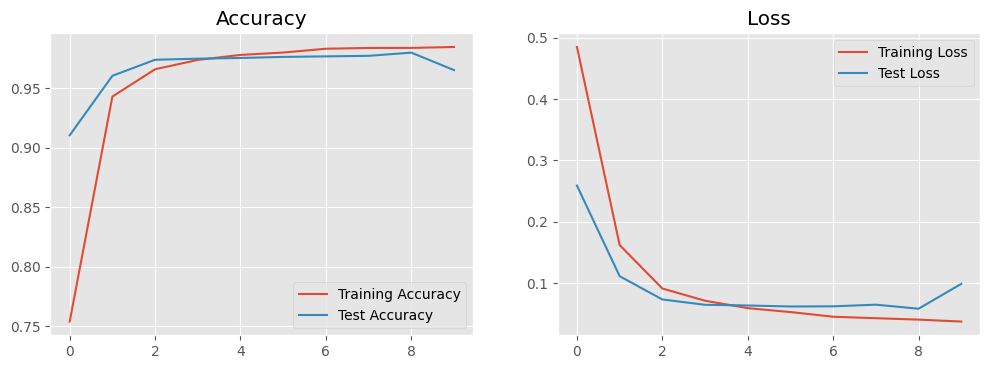

In [9]:
# Plot accuracy vs. epochs.
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()
plt.title("Accuracy")

# Plot loss vs. epochs.
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.title("Loss")
plt.show()